In [4]:
import torch
from torch.autograd import Variable
import utils
import dataset
from PIL import Image
import models.crnn as crnn

model_path = './weights/crnn_lstm.pth'
img_path = './data/demo.png'

alphabet = utils.alphabetChinese
model = crnn.CRNN(32, 1, alphabet, 256)

    
if torch.cuda.is_available():
    model = model.cuda()

print('loading pretrained model from %s' % model_path)

model.load_weights(model_path)
converter = utils.strLabelConverter(alphabet)

transformer = dataset.resizeNormalize((100, 32))

image = Image.open(img_path).convert('L')
image = transformer(image)

if torch.cuda.is_available():
    image = image.cuda()

image = image.view(1, *image.size())
image = Variable(image)


### 分步骤拆解输出
o = image
print('### CNN + RNN模型输出结果')
print('- input shape:', o.shape)
for m in model.cnn.children():
    o = m(o)
    print("- ", m)
    print(': ', o.shape)

b, c, h, w = o.size()
assert h == 1, "the height of conv must be 1"
o = o.squeeze(2) # remove dim(2), h -> [N, 512, 26]
print("- squeeze(2)")
print(': ', o.shape)

o = o.permute(2, 0, 1)  # [w, b, c] => [26, N, 512]
print("- permute(2, 0, 1)")
print(': ', o.shape)


for m in model.rnn.children():
    o, s = m.rnn(o)
    print("- ", m.rnn)
    print(': ', o.shape)
    
    o = m.embedding(o)
    print("- ", m.embedding)
    print(': ', o.shape)
    
preds = o

# 直接model输出
#model.eval()
#preds = model(image)

max_val, preds = preds.max(2)
print('- max(2)', preds.shape)

#preds = preds.transpose(1, 0).contiguous().view(-1)
preds = preds.view(-1)
print('- view(-1)', preds.shape)


print('### 模型结果')
preds_size = Variable(torch.IntTensor([preds.size(0)]))
raw_pred = converter.decode(preds.data, preds_size.data, raw=True)
sim_pred = converter.decode(preds.data, preds_size.data, raw=False)
print('- raw_pred size: %d, sim_pred size: %d' %(len(raw_pred), len(sim_pred)))
print('- decode result: %-20s => %-20s' % (raw_pred, sim_pred))


loading pretrained model from ./weights/crnn_lstm.pth
### CNN + RNN模型输出结果
- input shape: torch.Size([1, 1, 32, 100])
-  Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
:  torch.Size([1, 64, 32, 100])
-  ReLU(inplace=True)
:  torch.Size([1, 64, 32, 100])
-  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
:  torch.Size([1, 64, 16, 50])
-  Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
:  torch.Size([1, 128, 16, 50])
-  ReLU(inplace=True)
:  torch.Size([1, 128, 16, 50])
-  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
:  torch.Size([1, 128, 8, 25])
-  Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
:  torch.Size([1, 256, 8, 25])
-  BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
:  torch.Size([1, 256, 8, 25])
-  ReLU(inplace=True)
:  torch.Size([1, 256, 8, 25])
-  Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
:  torch.Size(

### Tensor Shape变化总结
1. cnn input [N, 1, 32, 100] => output [N, 512, 1, 26]  
2. w = input_w/4 + 1 + 1 - 1 = input_w/4 + 1,   h = input_h/16-1(最后输出必须为1)
3. 默认input [w(100), h(32)] -> [w(26), h(1)]

### CNN + RNN模型输出结果
- input shape: torch.Size([1, 1, 32, 100])
-  Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
:  torch.Size([1, 64, 32, 100])
-  ReLU(inplace=True)
:  torch.Size([1, 64, 32, 100])
-  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
:  torch.Size([1, 64, 16, 50])
-  Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
:  torch.Size([1, 128, 16, 50])
-  ReLU(inplace=True)
:  torch.Size([1, 128, 16, 50])
-  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
:  torch.Size([1, 128, 8, 25])
-  Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
:  torch.Size([1, 256, 8, 25])
-  BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
:  torch.Size([1, 256, 8, 25])
-  ReLU(inplace=True)
:  torch.Size([1, 256, 8, 25])
-  Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
:  torch.Size([1, 256, 8, 25])
-  ReLU(inplace=True)
:  torch.Size([1, 256, 8, 25])
-  MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
:  torch.Size([1, 256, 4, 26])
-  Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
:  torch.Size([1, 512, 4, 26])
-  BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
:  torch.Size([1, 512, 4, 26])
-  ReLU(inplace=True)
:  torch.Size([1, 512, 4, 26])
-  Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
:  torch.Size([1, 512, 4, 26])
-  ReLU(inplace=True)
:  torch.Size([1, 512, 4, 26])
-  MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
:  torch.Size([1, 512, 2, 27])
-  Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1))
:  torch.Size([1, 512, 1, 26])
-  BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
:  torch.Size([1, 512, 1, 26])
-  ReLU(inplace=True)
:  torch.Size([1, 512, 1, 26])
- squeeze(2)
:  torch.Size([1, 512, 26])
- permute(2, 0, 1)
:  torch.Size([26, 1, 512])
-  LSTM(512, 256, bidirectional=True)
:  torch.Size([26, 1, 512])
-  Linear(in_features=512, out_features=256, bias=True)
:  torch.Size([26, 1, 256])
-  LSTM(256, 256, bidirectional=True)
:  torch.Size([26, 1, 512])
-  Linear(in_features=512, out_features=37, bias=True)
:  torch.Size([26, 1, 37])

loading pretrained model from ./weights/crnn_lstm.pth


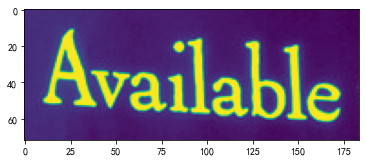

### 模型结果
- raw_pred size: 21, sim_pred size: 9
- decode result: a-----v-a-i-la--bllee => available           


In [15]:
from PIL import Image
import models.crnn as crnn
import matplotlib.pyplot as plt

model_path = './weights/crnn_lstm.pth'
img_path = './data/demo.png'

model = crnn.CRNN()
print('loading pretrained model from %s' % model_path)
model.load_weights(model_path)

image = Image.open(img_path).convert('L')
plt.imshow(image)
plt.show()
preds, raw_pred,sim_pred = model.predict(image)


print('### 模型结果')
print('- raw_pred size: %d, sim_pred size: %d' %(len(raw_pred), len(sim_pred)))
print('- decode result: %-20s => %-20s' % (raw_pred, sim_pred))


loading pretrained model from ./weights/netCRNN_True.pth
(63, 446)
### 模型结果
- raw_pred size: 26, sim_pred size: 7
- decode result: 胡---思---乱--想---的--后------果 => 胡思乱想的后果             


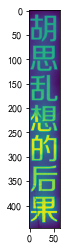

In [1]:
import torch
from PIL import Image
import models.crnn as crnn
import cv2
import matplotlib.pyplot as plt

model_path = './weights/netCRNN_True.pth'
img_path = './data/demo6.jpeg'

model = crnn.CRNN(lstmFlag=True)
print('loading pretrained model from %s' % model_path)
model.load_weights(model_path)

image = Image.open(img_path).convert('L')
plt.imshow(image)
print(image.size)

preds, raw_pred,sim_pred = model.predict(image)

print('### 模型结果')
print('- raw_pred size: %d, sim_pred size: %d' %(len(raw_pred), len(sim_pred)))
print('- decode result: %-20s => %-20s' % (raw_pred, sim_pred))
